In [13]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
#Audio-data augmentation
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
#Various audio processing functionalities
import librosa
#Just to find the ceil 
import math
#Visualization of model history
import matplotlib.pyplot as plt
#Memory maps and various computations involving arrays
import numpy as np
#File read/information retrieval
import os
#CSV file manipulation
import pandas as pd
#To shuffle and split the dataset. We use it here to split indices of memory maps.
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import time
from tensorflow.python.keras.saving import hdf5_format
import h5py
import gc

##### Assumptions 
- Any class in csv file should have a viable number of songs in them. The amount of songs we take for training and testing is equivalent to the n(songs) of that class which has the minimum amount of songs -> to balance the dataset.
- Don't have variables named X,y,X_train ,X_validation,X_test,y_train,y_validation,y_test in this script since it will either get deleted or the memory maps won't get created. We are using global so warning
- Memory maps on creation have a default value of 0 array with shape we mention on creation  [To extract the actual size of added data]

In [2]:
def Augment_Song(signal,sample_rate,n_augmentations):
    signals=list()
    signals.append(signal)
    #print("Original")
    if(n_augmentations<=0):
        return signals 
    transform1 = AddGaussianNoise(min_amplitude=0.001,max_amplitude=0.015,p=1.0)
    augmented_sound = transform1(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Gaussian Noise")
    if(n_augmentations<=1):
        return signals 
    transform2 =  TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
    augmented_sound = transform2(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Time Stretch")
    if(n_augmentations<=2):
        return signals 
    transform3=PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
    augmented_sound=transform3(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Pitch Shift")
    if(n_augmentations<=3):
        return signals 
    transform4=Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)
    augmented_sound=transform4(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Shift")
    if(n_augmentations<=4):
        return signals 
    transform5= Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-1, max_semitones=1, p=0.5),
    Shift(min_fraction=-0.2, max_fraction=0.2, p=0.5),
    ])
    augmented_sound=transform5(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Combined Transforms") 
    return signals

In [3]:
def create_csv(DATASET_PATH,CSV_PATH):
    """
    DATASET_PATH -> Directory which will have folders (classes) of audio files.
    CSV_PATH -> Path of csv file
    CSV file structure : ['Filename','Genre','Path']
        Filename is the name of the audio file including extension
        Genre will be the name of the parent folder of the audio file. This assumes audio files are stored in folders having their respective class (genre) name.
        Path will be the path of the audio file including the filename as well.
    """
    df=pd.DataFrame(list(),columns=["Filename","Genre","Path"])
    for genre_folder in next(os.walk(DATASET_PATH))[1]:
        for file in next(os.walk(os.path.join(DATASET_PATH,genre_folder)))[2]:
            df.loc[len(df.index)]=[file,genre_folder.title(),os.path.join(DATASET_PATH,genre_folder,file)]
    df.to_csv(CSV_PATH,index=False)
    print(f"Path of the created csv file : {CSV_PATH}. If the dataset doesn't change in the future, Pass the path of that csv file as the function parameter to avoid writing csv file over and over again.")

In [24]:
def create_test_csv(CSV_PATH,TEST_CSV_PATH,test_percentage=10):
    """
    """
    #Decide test_set percentage for a viable observation of performance
    #create test_csv file having 1% of main_csv file
    #remove test from main_csv and add (new calculated 1%-existing test size) to it as the main_csv file grows and evaluate previous models on new test_csv file
    df=pd.read_csv(CSV_PATH)
    df=df.drop_duplicates(['Path'])
    genre_count_list=list(df["Genre"].value_counts())
    required_test_set_size=int(min(genre_count_list)/test_percentage)
    print(f"Aiming for test size : {required_test_set_size}")
    try:
        test_df=pd.read_csv(TEST_CSV_PATH)
        test_df=test_df.drop_duplicates(['Path'])
        for genre in list(df["Genre"].unique()):
            try:
                current_test_set_size_for_genre=test_df['Genre'].value_counts()[genre]
            #If genre doesn't exist in test csv file
            except KeyError:
                print(f"Genre : {genre} doesn't exist in test csv file.")
                current_test_set_size_for_genre=0
            if(current_test_set_size_for_genre>required_test_set_size):
                print(f"Test csv contains {current_test_set_size_for_genre} records for {genre} which is more than required size : {required_test_set_size}. Removing {current_test_set_size_for_genre-required_test_set_size} records from test.")
                #Taking a random sample equal to the extra elements in test.
                temp_df=test_df.loc[test_df["Genre"]==genre].sample(n=current_test_set_size_for_genre-required_test_set_size)
                #Removing that sample from test csv
                test_df=pd.merge(test_df,temp_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
            elif(current_test_set_size_for_genre<required_test_set_size):
                print(f"Required test size is : {required_test_set_size} for {genre} which is more than current test size : {current_test_set_size_for_genre}. Adding {required_test_set_size-current_test_set_size_for_genre} records to test.")
                #Removing rows that already exist in test csv file
                temp_df=pd.merge(df,test_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
                #Then taking a random sample so that our test size reaches required size.
                temp_df=temp_df.loc[temp_df["Genre"]==genre].sample(n=required_test_set_size-current_test_set_size_for_genre)
                #Adding that sample to test csv
                test_df=pd.concat([test_df, temp_df], ignore_index=True, sort=False)
            else:
                pass
        test_df.to_csv(TEST_CSV_PATH,index=False)
    except FileNotFoundError:
        test_df=pd.DataFrame(list(),columns=['Filename','Artist','Title','Genre','Path','Source'])
        for genre in list(df["Genre"].unique()):
            #Taking a random sample from the dataset
            temp_df=df.loc[df["Genre"]==genre].sample(n=required_test_set_size)
            test_df = pd.concat([test_df, temp_df], ignore_index=True, sort=False)
        test_df.to_csv(TEST_CSV_PATH,index=False)
        print(f"Path of the created test csv file : {TEST_CSV_PATH}. Pass the path for future iterations.")   
    display(test_df)

In [5]:
def load_data(df,MEMORY_MAPPING_PATH,ERROR_PATH,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,n_augmentations):
    try:
        #Deleting memory map files so that we don't face issues when creating memory maps here.
        clean(MEMORY_MAPPING_PATH,"files",file_list=["X","y"])
        try:
            error_df=pd.read_csv(ERROR_PATH)
        except FileNotFoundError:
            error_df=pd.DataFrame(list(),columns=['Filename','Genre','Path','Segment','Error'])

        genre_list=sorted(list(df["Genre"].unique()))
        print(f"Classes present in the dataframe : {genre_list}")
        SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
        samples_per_segment = int(SAMPLES_PER_TRACK / n_segments)
        n_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
        
        max_input_size=len(df.index)*(n_augmentations+1)*n_segments
        temp_X = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X.mymemmap"), dtype='float64', mode='w+', shape=(max_input_size, n_mfcc_vectors_per_segment, n_mfcc))
        temp_y = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y.mymemmap"), dtype='uint8', mode='w+', shape=(max_input_size,))
        print("Empty memortemp_y maps X.mymemmap and y.mymemmap created.")

        #audio file count
        song_count=1
        #viable array count
        count=0
        test_null_signal_array=np.zeros((n_mfcc_vectors_per_segment,n_mfcc))
        test_null_signal_array[:,0]=-1131.370849898476
        for index,row in df.iterrows():
            starting_time=time.time()
            print(f"{song_count}. {row['Filename']} : {genre_list.index(row['Genre'])}")
            try:
                signal, sample_rate = librosa.load(row['Path'], sr=SAMPLE_RATE,duration=TRACK_DURATION)
            except Exception as e:
                error_df.loc[len(error_df.index)]=[row["Filename"],row["Genre"],row["Path"],"",e]
                print("ERROR : Couldn't read file")
                continue
            signals=Augment_Song(signal,sample_rate,n_augmentations)
            for signal in signals:
                for d in range(n_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    #n_mfcc values beyond 128 produces 128 mfcc only.
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
                    
                    #This check makes sure the shape of the input is consistent. Assuming this stays in, we can assume shape to be (n_mfcc_vectors_per_segment,n_mfcc) for each segment
                    if(mfcc.shape==(n_mfcc_vectors_per_segment,n_mfcc)):
                        if(np.all(np.equal(test_null_signal_array,mfcc))):
                            print(f"ERROR : Segment {d} skipped.")
                            error_df.loc[len(error_df.index)]=[row["Filename"],row["Genre"],row["Path"],d,"mfcc array equal to array produced if signal is a zero array."]
                            continue
                        if(np.any(np.isnan(mfcc))):
                            print(f"ERROR : Segment {d} skipped.")
                            error_df.loc[len(error_df.index)]=[row["Filename"],row["Genre"],row["Path"],d,"Null value present in mfcc array."]
                            continue
                        if(np.any(np.isinf(mfcc))):
                            print(f"ERROR : Segment {d} skipped.")
                            error_df.loc[len(error_df.index)]=[row["Filename"],row["Genre"],row["Path"],d,"Inf value present in mfcc array."]
                            continue
                        temp_X[count,:]=mfcc
                        temp_y[count]=genre_list.index(row['Genre'])
                        count+=1
                    else:
                        print(f"ERROR : Segment {d} skipped.")
                        error_df.loc[len(error_df.index)]=[row["Filename"],row["Genre"],row["Path"],d,"Shape of mfcc array not consistent with our calculation"]
            song_count+=1
        error_df.to_csv(ERROR_PATH,index=False)
        ending_time=time.time()
        del temp_X
        del temp_y
        gc.collect()
        print("Data loaded : ",ending_time-starting_time,"seconds",end="\n")
    except Exception as e:
        print("Exception occured :",e)
        try:
            del temp_X
        except NameError:
            pass
        try:
            del temp_y
        except NameError:
            pass
        gc.collect()
        clean(MEMORY_MAPPING_PATH,"files",file_list=["X","y"])
        raise Exception(e)
    except KeyboardInterrupt:
        #If user interrupts this process, X and y can have corrupt values since it was in the middle of adding data. 
        #We are removing the memory map files as well as deleting the variables for safety.
        #deleting variables required since referenced to the memory map will still be in memory 
        #which will not allow us to run the code again since WinError which tells us some other process is using the file.
        try:
            del temp_X
        except NameError:
            pass
        try:
            del temp_y
        except NameError:
            pass
        gc.collect()
        clean(MEMORY_MAPPING_PATH,"files",file_list=["X","y"])
        raise KeyboardInterrupt("Deleted memory maps and variables from memory since values will be corrupt")

In [6]:
def clean(MEMORY_MAPPING_PATH,s,file_list=None):
    #if(s=="csv")
    if(file_list==None):
        file_list=["X","y","X_train","X_validation","X_test","y_train","y_validation","y_test"]
    if((s=="variables") or (s=="full")):
        for variable in file_list:
            #myVars = locals() 
            #del doesn't work if locals since it returns a copy of the directory not the directory itself like globals. So for our usecase, we have to use globals [may be dangerous.]
            myVars = globals()
            try:
                del myVars[variable]
            except NameError:
                continue
            except KeyError:
                continue
        gc.collect()
    if((s=="files") or (s=="full")):
        for file in file_list:
            try:
                os.remove(os.path.join(MEMORY_MAPPING_PATH,file+".mymemmap"))
            except FileNotFoundError:
                continue

In [23]:
def Preprocess(MEMORY_MAPPING_PATH,ERROR_PATH,CSV_PATH,TEST_CSV_PATH,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,n_augmentations):
    """
    """
    Function_start_time=time.time()
    
    global X
    global y
    global X_train 
    global X_validation
    global X_test
    global y_train
    global y_validation
    global y_test 
    
    
    df=pd.read_csv(CSV_PATH)
    print("CSV file read.")
    df=df.drop_duplicates(['Path'])
    
    test_percentage=10
    create_test_csv(CSV_PATH,TEST_CSV_PATH,test_percentage)
    test_df=pd.read_csv(TEST_CSV_PATH)
    df=pd.merge(df,test_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    genre_count_list=list(df["Genre"].value_counts())
    balanced_df=pd.DataFrame(list(),columns=['Filename','Artist','Title','Genre','Path','Source'])
    for genre in list(df["Genre"].unique()):
        #Taking a random sample from the dataset
        temp_df=df.loc[df["Genre"]==genre].sample(n=min(genre_count_list))
        balanced_df = pd.concat([balanced_df, temp_df], ignore_index=True, sort=False)
    print(f"Dataset balanced to have only {min(genre_count_list)} data points per class.")
    #To shuffle. Not needed since we are using train test split for shuffling which is a better way since this will only shuffle songs not segments as well.
    #df=df.sample(n = len(df.index))
    
    #delete memory mapping if present in directory
    file_list=["X","y","X_train","X_validation","X_test","y_train","y_validation","y_test"]
    clean(MEMORY_MAPPING_PATH,"full",file_list)
    try:
        os.remove(ERROR_PATH)
    except FileNotFoundError:
        pass
    try:
        SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
        samples_per_segment = int(SAMPLES_PER_TRACK / n_segments)
        n_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
        #Loading for training set.
        load_data(df,MEMORY_MAPPING_PATH,ERROR_PATH,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,n_augmentations)
        max_input_size=len(balanced_df.index)*(n_augmentations+1)*n_segments
        X = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X.mymemmap"), dtype='float64', mode='r', shape=(max_input_size, n_mfcc_vectors_per_segment, n_mfcc))
        y = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y.mymemmap"), dtype='uint8', mode='r', shape=(max_input_size,))
        #Getting the actual size of the training set since we might encounter segment errors and unreadable files.
        actual_size=len(X)
        d=np.zeros((n_mfcc_vectors_per_segment, n_mfcc),dtype=float)
        for i in range(-1,-len(X),-1):
            if(np.array_equal(X[-i],d)):
                actual_size-=1
        index_list=np.arange(0, actual_size, 1, dtype=int)
        #Splitting from training set, the validation set.
        validation_ratio=0.2
        train_indices,validation_indices=train_test_split(index_list,test_size=validation_ratio,shuffle=True)
        print(f"Splitting X in the ratio : {validation_ratio}. \n(Training + Validation) set size : {actual_size}. \nTrain set size : {len(train_indices)} \nValidation set size : {len(validation_indices)}")

        #Creating empty memory maps for train and validation
        X_train = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_train.mymemmap"), dtype='float64', mode='w+', shape=(len(train_indices), n_mfcc_vectors_per_segment, n_mfcc))
        X_validation = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_validation.mymemmap"), dtype='float64', mode='w+', shape=(len(validation_indices), n_mfcc_vectors_per_segment, n_mfcc))
        y_train = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_train.mymemmap"), dtype='uint8', mode='w+', shape=(len(train_indices),))
        y_validation = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_validation.mymemmap"), dtype='uint8', mode='w+', shape=(len(validation_indices),))
        print("Empty memory maps created for train and validation")

        #Placing respective values in validation and train memory maps.
        for index in range(0,actual_size):
            #print(index,end=":")
            if(index in train_indices):
                #print("train")
                X_train[np.where(train_indices == index)[0][0],:]=X[index]
                y_train[np.where(train_indices == index)[0][0]]=y[index]
            elif(index in validation_indices):
                #print("validation")
                X_validation[np.where(validation_indices == index)[0][0],:]=X[index]
                y_validation[np.where(validation_indices == index)[0][0]]=y[index]
            else:
                print(f"ERROR : Index {count} not in train or validation indices")
       
        print("Train and validation memory maps written.")
        clean(MEMORY_MAPPING_PATH,"variables",["X","y"])
        
        #Avoiding augmentation here since we assume test to be the actual real representation that we want to perform well on.
        load_data(test_df,MEMORY_MAPPING_PATH,ERROR_PATH,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,0)
        max_input_size=len(test_df.index)*(n_augmentations+1)*n_segments
        X = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X.mymemmap"), dtype='float64', mode='r', shape=(max_input_size, n_mfcc_vectors_per_segment, n_mfcc))
        y = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y.mymemmap"), dtype='uint8', mode='r', shape=(max_input_size,))
        actual_size=len(X)
        for i in range(-1,-len(X),-1):
            if(np.array_equal(X[-i],d)):
                actual_size-=1
        print(f"Test set size : {actual_size}")
        X_test = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_test.mymemmap"), dtype='float64', mode='w+', shape=(actual_size, n_mfcc_vectors_per_segment, n_mfcc))
        y_test = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_test.mymemmap"), dtype='uint8', mode='w+', shape=(actual_size,))
        X_test[:]=X[:actual_size]
        y_test[:]=y[:actual_size]
        print("Test memory map written.")
        clean(MEMORY_MAPPING_PATH,"variables",file_list)
    except Exception as e:
        print("Exception occured : ",e)
        clean(MEMORY_MAPPING_PATH,"full",file_list)
        raise Exception(e)
    except KeyboardInterrupt:
        clean(MEMORY_MAPPING_PATH,"full",file_list)
        raise KeyboardInterrupt("Deleted memory maps and variables from memory since values will be corrupt")
    Function_end_time=time.time()
    print(f"\n\n\nPreprocessing Execution Time : {Function_end_time-Function_start_time}")

In [8]:
def build_model(input_shape,n_classes):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(n_classes, activation='softmax'))

    return model

In [9]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [10]:
def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)
    #(130,13) array produced for each segment. Therefore (n_segments,130,13)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [11]:
def create_dataset(MEMORY_MAPPING_PATH,n_mfcc,n_segments,n_mfcc_vectors_per_segment):
    """
    """
    s=time.time()
    memory_map_directory_file_list=next(os.walk(MEMORY_MAPPING_PATH))[2]
    required_memory_maps_list=["X_train.mymemmap","X_validation.mymemmap","X_test.mymemmap","y_train.mymemmap","y_validation.mymemmap","y_test.mymemmap"]
    #If the required maps not in the given directory
    if(not(all(item in memory_map_directory_file_list for item in required_memory_maps_list))):
        raise ValueError('Memory Map directory may be incorrect since required memory maps not found. Use remove=True if memory maps were not created during the previous iterations.')
        
    #Here 8 is because float64 uses 8 bytes. [float64 uses 64 bits -> 8 bytes]
    file_size = os.path.getsize(os.path.join(MEMORY_MAPPING_PATH,"X_train.mymemmap"))
    train_size=int(file_size/(n_mfcc_vectors_per_segment*n_mfcc*8))
    
    file_size = os.path.getsize(os.path.join(MEMORY_MAPPING_PATH,"X_validation.mymemmap"))
    validation_size=int(file_size/(n_mfcc_vectors_per_segment*n_mfcc*8))
    
    file_size = os.path.getsize(os.path.join(MEMORY_MAPPING_PATH,"X_test.mymemmap"))
    test_size=int(file_size/(n_mfcc_vectors_per_segment*n_mfcc*8))
    print(f"Train, Validation, Test Memory maps of sizes {train_size}, {validation_size}, {test_size} read respectively")
    
    X_train = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_train.mymemmap"), dtype='float64', mode='r', shape=(train_size, n_mfcc_vectors_per_segment, n_mfcc))
    X_validation = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_validation.mymemmap"), dtype='float64', mode='r', shape=(validation_size,n_mfcc_vectors_per_segment, n_mfcc))
    X_test = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_test.mymemmap"), dtype='float64', mode='r', shape=(test_size, n_mfcc_vectors_per_segment, n_mfcc))
    y_train = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_train.mymemmap"), dtype='uint8', mode='r', shape=(train_size,))
    y_validation = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_validation.mymemmap"), dtype='uint8', mode='r', shape=(validation_size,))
    y_test = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_test.mymemmap"), dtype='uint8', mode='r', shape=(test_size,))


    input_example_shape =  X_train[0].shape
    input_dtype = np.float64
    print(f"Input example shape : {input_example_shape} Input datatype : {input_dtype}")

    # generator function
    def X_train_generator():
        return iter(X_train)
    def X_validation_generator():
        return iter(X_validation)
    def X_test_generator():
        return iter(X_test)

    # create tf dataset from generator fn
    X_train_dataset = tf.data.Dataset.from_generator(
        generator=X_train_generator,
        output_types=input_dtype,
        output_shapes=input_example_shape,
    )
    # create tf dataset from generator fn
    X_validation_dataset = tf.data.Dataset.from_generator(
        generator=X_validation_generator,
        output_types=input_dtype,
        output_shapes=input_example_shape,
    )
    # create tf dataset from generator fn
    X_test_dataset = tf.data.Dataset.from_generator(
        generator=X_test_generator,
        output_types=input_dtype,
        output_shapes=input_example_shape,
    )

    label_example_shape=y_train[0].shape
    label_data_dtype=np.uint8
    print(f"Label example shape : {label_example_shape} Label datatype : {label_data_dtype}")

    # generator function
    def y_train_generator():
        return iter(y_train)
    def y_validation_generator():
        return iter(y_validation)
    def y_test_generator():
        return iter(y_test)

    # create tf dataset from generator fn
    y_train_dataset = tf.data.Dataset.from_generator(
        generator=y_train_generator,
        output_types=label_data_dtype,
        output_shapes=label_example_shape
    )
    # create tf dataset from generator fn
    y_validation_dataset = tf.data.Dataset.from_generator(
        generator=y_validation_generator,
        output_types=label_data_dtype,
        output_shapes=label_example_shape
    )
    # create tf dataset from generator fn
    y_test_dataset = tf.data.Dataset.from_generator(
        generator=y_test_generator,
        output_types=label_data_dtype,
        output_shapes=label_example_shape
    )

    train_dataset= tf.data.Dataset.zip((X_train_dataset, y_train_dataset))
    validation_dataset= tf.data.Dataset.zip((X_validation_dataset, y_validation_dataset))
    test_dataset= tf.data.Dataset.zip((X_test_dataset, y_test_dataset))

    def RESHAPE(tensor_value,label):
        tensor_value=tf.reshape(tensor_value,(input_example_shape[0], input_example_shape[1],1))
        tensor_value.set_shape(tensor_value.shape)
        return (tensor_value,label)

    train_dataset = train_dataset.map(RESHAPE)
    validation_dataset = validation_dataset.map(RESHAPE)
    test_dataset = test_dataset.map(RESHAPE)

    train_batch=train_dataset.batch(32)
    validation_batch=validation_dataset.batch(32)
    test_batch=test_dataset.batch(32)

    print(f"Dataset created : {time.time()-s} Seconds")
    return train_batch,validation_batch,test_batch

In [12]:
def training(MEMORY_MAPPING_PATH=None,ERROR_PATH=None,MODEL_SAVE_DIRECTORY=None,DATASET_PATH=None,CSV_PATH=None,TEST_CSV_PATH=None,remove=True,SAMPLE_RATE=22050,TRACK_DURATION = 30,n_mfcc=13,n_fft=2048,hop_length=512,n_segments=10,n_augmentations=0):
    """
    MEMORY_MAPPING_PATH is where we will store the mfcc numpy arrays of train,test,validation input and labels. [6 files total]
    ERROR_PATH -> csv file which will include files that are unreadable or segments inside those files that are corrupt.
    MODEL_SAVE_DIRECTORY -> The path where we want to save the model.
    If no csv file, assuming mp3/wav files are in respective genre folder where folder name = genre label
    If there is a csv file with dataset, columns = [Filename,Genre,Path]
    DATASET_PATH must be given if csv file of audio files is not there.
    DATASET_PATH AND CSV_PATH need not be given since we will read directly from the csv file - the path of the audio files.
    remove -> whether we want to remove existing memory maps or not. This WILL avoid preprocessing. If remove = True and memory maps not in location, will throw error. 
    SAMPLE_RATE= The number of data points per second in the audio file. Default is 22050.
    TRACK_DURATION = 30
    n_mfcc=13
    n_fft=2048
    hop_length=512
    n_segments=10
    n_augmentations=0
    """
    s=time.time()
    #numpy memory mapping gets created, error_csv gets created
    if((remove==True) or (CSV_PATH==None) or (MEMORY_MAPPING_PATH==None)):
        if(CSV_PATH==None and DATASET_PATH==None):
            raise ValueError('Either dataset path or csv path must be given')
        elif(CSV_PATH==None):
            #csv file will be stored in dataset directory itself
            CSV_PATH=os.path.join(DATASET_PATH,"Audio_Dataset.csv")
            create_csv(DATASET_PATH,CSV_PATH)
        else:
            pass
        if(ERROR_PATH==None):
            ERROR_PATH=os.path.join(os.path.split(CSV_PATH)[0],"Error.csv")
        if(TEST_CSV_PATH==None):
            TEST_CSV_PATH=os.path.join(os.path.split(CSV_PATH)[0],"Test.csv")
        if(MEMORY_MAPPING_PATH==None):
            MEMORY_MAPPING_PATH=os.path.split(CSV_PATH)[0]
        Preprocess(MEMORY_MAPPING_PATH,ERROR_PATH,CSV_PATH,TEST_CSV_PATH,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,n_augmentations)
    if(MODEL_SAVE_DIRECTORY==None):
        MODEL_SAVE_DIRECTORY=os.path.join(os.path.split(CSV_PATH)[0],"Model.h5")
        
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
    samples_per_segment = int(SAMPLES_PER_TRACK / n_segments)
    n_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    train_batch,validation_batch,test_batch=create_dataset(MEMORY_MAPPING_PATH,n_mfcc,n_segments,n_mfcc_vectors_per_segment)

    df=pd.read_csv(CSV_PATH)
    n_classes=len(list(df["Genre"].unique()))
    genre_list=sorted(list(df["Genre"].unique()))
    del df
    input_shape=(n_mfcc_vectors_per_segment, n_mfcc,1)
    model=build_model(input_shape,n_classes)
    print(f"Model built with input shape : {input_shape} and output classes : {n_classes}")

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print("Model compiled")
    model.summary()

    history = model.fit(train_batch,epochs=50,validation_data=validation_batch,verbose=1)
    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(test_batch, verbose=2)
    #Performance csv.loc[len(index)]=[MODEL_SAVE_DIRECTORY,test_loss,test_acc]  
    print('\nTest accuracy:', test_acc)

    with h5py.File(MODEL_SAVE_DIRECTORY, mode='w') as f:
        hdf5_format.save_model_to_hdf5(model, f)
        f.attrs['Genre_List'] = genre_list
        f.attrs["SAMPLE_RATE"] = SAMPLE_RATE
        f.attrs["TRACK_DURATION"]=TRACK_DURATION
        f.attrs["n_mfcc"]=n_mfcc
        f.attrs["n_fft"]=n_fft
        f.attrs["hop_length"]=hop_length
        f.attrs["n_segments"]=n_segments
    print(f"MODEL SUCESSFULLY SAVED AT {MODEL_SAVE_DIRECTORY}")
    print(f"Training Execution Time : {time.time()-s} Seconds")

In [13]:
DATASET_PATH="D:/Downloads/MGR Data/Data/GTZAN/Data/genres_original"
SAMPLE_RATE=22050
TRACK_DURATION = 30
n_mfcc=13
n_fft=2048
hop_length=512
n_segments=10
n_augmentations=0

Path of the created csv file : D:/Downloads/MGR Data/Data/GTZAN/Data/genres_original\Audio_Dataset.csv. If the dataset doesn't change in the future, Pass the path of that csv file as the function parameter to avoid writing csv file over and over again.
CSV file read.
Aiming for test size : 10
Path of the created test csv file : D:/Downloads/MGR Data/Data/GTZAN/Data/genres_original\Test.csv. Pass the path for future iterations.


,Filename,Artist,Title,Genre,Path,Source
0,blues.00048.wav,NaN,NaN,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
1,blues.00032.wav,NaN,NaN,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
2,blues.00013.wav,NaN,NaN,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
3,blues.00084.wav,NaN,NaN,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
4,blues.00010.wav,NaN,NaN,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
...,...,...,...,...,...,...
95,rock.00079.wav,NaN,NaN,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
96,rock.00046.wav,NaN,NaN,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
97,rock.00094.wav,NaN,NaN,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
98,rock.00095.wav,NaN,NaN,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN


Dataset balanced to have only 90 data points per class.
Classes present in the dataframe : ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
Empty memortemp_y maps X.mymemmap and y.mymemmap created.
1. blues.00000.wav : 0
2. blues.00001.wav : 0
3. blues.00002.wav : 0
4. blues.00003.wav : 0
5. blues.00004.wav : 0
6. blues.00005.wav : 0
7. blues.00007.wav : 0
8. blues.00008.wav : 0
9. blues.00009.wav : 0
10. blues.00011.wav : 0
11. blues.00012.wav : 0
12. blues.00014.wav : 0
13. blues.00015.wav : 0
14. blues.00016.wav : 0
15. blues.00017.wav : 0
16. blues.00018.wav : 0
17. blues.00019.wav : 0
18. blues.00020.wav : 0
19. blues.00021.wav : 0
20. blues.00022.wav : 0
21. blues.00023.wav : 0
22. blues.00024.wav : 0
23. blues.00025.wav : 0
24. blues.00026.wav : 0
25. blues.00027.wav : 0
26. blues.00028.wav : 0
27. blues.00029.wav : 0
28. blues.00030.wav : 0
29. blues.00031.wav : 0
30. blues.00033.wav : 0
31. blues.00034.wav : 0
32. blues.00035.wav 

300. disco.00031.wav : 3
301. disco.00032.wav : 3
302. disco.00033.wav : 3
303. disco.00034.wav : 3
304. disco.00035.wav : 3
305. disco.00036.wav : 3
306. disco.00037.wav : 3
307. disco.00038.wav : 3
308. disco.00039.wav : 3
309. disco.00043.wav : 3
310. disco.00044.wav : 3
311. disco.00045.wav : 3
312. disco.00046.wav : 3
313. disco.00048.wav : 3
314. disco.00050.wav : 3
315. disco.00051.wav : 3
316. disco.00052.wav : 3
317. disco.00053.wav : 3
318. disco.00054.wav : 3
319. disco.00056.wav : 3
320. disco.00057.wav : 3
321. disco.00058.wav : 3
322. disco.00059.wav : 3
323. disco.00060.wav : 3
324. disco.00061.wav : 3
325. disco.00062.wav : 3
326. disco.00063.wav : 3
327. disco.00064.wav : 3
328. disco.00066.wav : 3
329. disco.00067.wav : 3
330. disco.00068.wav : 3
331. disco.00069.wav : 3
332. disco.00071.wav : 3
333. disco.00072.wav : 3
334. disco.00073.wav : 3
335. disco.00074.wav : 3
336. disco.00075.wav : 3
337. disco.00076.wav : 3
338. disco.00077.wav : 3
339. disco.00078.wav : 3


C:\Users\arviv\anaconda3\envs\MusicRecommendation\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


501. jazz.00056.wav : 5
502. jazz.00057.wav : 5
503. jazz.00059.wav : 5
504. jazz.00060.wav : 5
505. jazz.00061.wav : 5
506. jazz.00062.wav : 5
507. jazz.00063.wav : 5
508. jazz.00064.wav : 5
509. jazz.00066.wav : 5
510. jazz.00067.wav : 5
511. jazz.00068.wav : 5
512. jazz.00069.wav : 5
513. jazz.00070.wav : 5
514. jazz.00071.wav : 5
515. jazz.00072.wav : 5
516. jazz.00073.wav : 5
517. jazz.00074.wav : 5
518. jazz.00075.wav : 5
519. jazz.00076.wav : 5
520. jazz.00077.wav : 5
521. jazz.00078.wav : 5
522. jazz.00079.wav : 5
523. jazz.00080.wav : 5
524. jazz.00081.wav : 5
525. jazz.00082.wav : 5
526. jazz.00083.wav : 5
527. jazz.00084.wav : 5
528. jazz.00085.wav : 5
529. jazz.00086.wav : 5
530. jazz.00087.wav : 5
531. jazz.00088.wav : 5
532. jazz.00089.wav : 5
533. jazz.00090.wav : 5
534. jazz.00091.wav : 5
535. jazz.00094.wav : 5
536. jazz.00095.wav : 5
537. jazz.00096.wav : 5
538. jazz.00097.wav : 5
539. jazz.00098.wav : 5
540. metal.00000.wav : 6
541. metal.00001.wav : 6
542. metal.000

835. rock.00028.wav : 9
836. rock.00029.wav : 9
837. rock.00030.wav : 9
838. rock.00031.wav : 9
839. rock.00032.wav : 9
840. rock.00033.wav : 9
841. rock.00034.wav : 9
842. rock.00036.wav : 9
843. rock.00037.wav : 9
844. rock.00038.wav : 9
845. rock.00039.wav : 9
846. rock.00040.wav : 9
847. rock.00041.wav : 9
848. rock.00042.wav : 9
849. rock.00043.wav : 9
850. rock.00044.wav : 9
851. rock.00045.wav : 9
852. rock.00047.wav : 9
853. rock.00048.wav : 9
854. rock.00049.wav : 9
855. rock.00050.wav : 9
856. rock.00051.wav : 9
857. rock.00052.wav : 9
858. rock.00054.wav : 9
859. rock.00055.wav : 9
860. rock.00056.wav : 9
861. rock.00057.wav : 9
862. rock.00058.wav : 9
863. rock.00059.wav : 9
864. rock.00060.wav : 9
865. rock.00061.wav : 9
866. rock.00062.wav : 9
867. rock.00063.wav : 9
868. rock.00064.wav : 9
869. rock.00065.wav : 9
870. rock.00066.wav : 9
871. rock.00067.wav : 9
872. rock.00068.wav : 9
873. rock.00069.wav : 9
874. rock.00070.wav : 9
875. rock.00071.wav : 9
876. rock.00072.

225/225 [==============================] - 5s 24ms/step - loss: 1.1153 - accuracy: 0.6046 - val_loss: 1.0461 - val_accuracy: 0.6279
Epoch 10/50
225/225 [==============================] - 5s 22ms/step - loss: 1.0761 - accuracy: 0.6212 - val_loss: 1.0116 - val_accuracy: 0.6440
Epoch 11/50
225/225 [==============================] - 5s 23ms/step - loss: 1.0336 - accuracy: 0.6288 - val_loss: 0.9955 - val_accuracy: 0.6535
Epoch 12/50
225/225 [==============================] - 5s 24ms/step - loss: 0.9995 - accuracy: 0.6432 - val_loss: 0.9728 - val_accuracy: 0.6657
Epoch 13/50
225/225 [==============================] - 5s 22ms/step - loss: 0.9631 - accuracy: 0.6564 - val_loss: 0.9783 - val_accuracy: 0.6641
Epoch 14/50
225/225 [==============================] - 5s 24ms/step - loss: 0.9337 - accuracy: 0.6708 - val_loss: 0.9494 - val_accuracy: 0.6696
Epoch 15/50
225/225 [==============================] - 5s 24ms/step - loss: 0.9031 - accuracy: 0.6778 - val_loss: 0.9407 - val_accuracy: 0.6796
Epoc

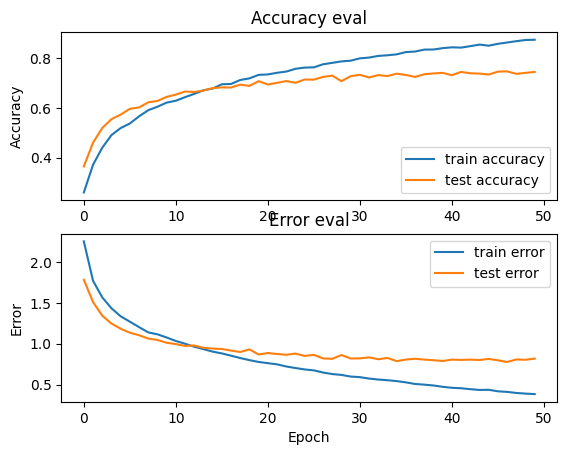

32/32 - 1s - loss: 1.2296 - accuracy: 0.6760

Test accuracy: 0.6759999990463257
MODEL SUCESSFULLY SAVED AT D:/Downloads/MGR Data/Data/GTZAN/Data/genres_original\Model.h5
Training Execution Time : 403.5170955657959 Seconds


In [14]:
training(DATASET_PATH=DATASET_PATH,remove=True)

In [18]:
CSV_PATH="D:/Downloads/MGR Data/Metadata/Datasets/GTZAN/GTZAN.csv"
MEMORY_MAPPING_PATH = "D:/Downloads/MGR Data/Metadata/Datasets/Combined/"
ERROR_PATH="D:/Downloads/MGR Data/Metadata/Datasets/Combined/Error.csv"
MODEL_SAVE_DIRECTORY="D:/Downloads/MGR Data/Models/EXPERIMENT 6.h5"
DATASET_PATH=None
TEST_CSV_PATH=None
SAMPLE_RATE=22050
TRACK_DURATION = 30
n_mfcc=13
n_fft=2048
hop_length=256
n_segments=10
n_augmentations=0

If memory mapping exists, will be deleted else will be created. Okay [Y/n]?
CSV file read.
Aiming for test size : 10
Path of the created test csv file : D:/Downloads/MGR Data/Metadata/Datasets/GTZAN\test.csv. Pass the path for future iterations.


,Filename,Artist,Title,Genre,Path,Source
0,blues.00050.wav,NaN,NaN,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
1,blues.00006.wav,NaN,NaN,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
2,blues.00069.wav,NaN,NaN,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
3,blues.00048.wav,NaN,NaN,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
4,blues.00051.wav,NaN,NaN,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
...,...,...,...,...,...,...
95,rock.00047.wav,NaN,NaN,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
96,rock.00026.wav,NaN,NaN,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
97,rock.00025.wav,NaN,NaN,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN
98,rock.00040.wav,NaN,NaN,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,NaN


Dataset balanced to have only 90 data points per class.
Classes present in the dataframe : ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
Empty memortemp_y maps X.mymemmap and y.mymemmap created.
1. blues.00000.wav : 0
2. blues.00001.wav : 0
3. blues.00002.wav : 0
4. blues.00003.wav : 0
5. blues.00004.wav : 0
6. blues.00005.wav : 0
7. blues.00007.wav : 0
8. blues.00008.wav : 0
9. blues.00009.wav : 0
10. blues.00010.wav : 0
11. blues.00011.wav : 0
12. blues.00012.wav : 0
13. blues.00013.wav : 0
14. blues.00014.wav : 0
15. blues.00015.wav : 0
16. blues.00016.wav : 0
17. blues.00017.wav : 0
18. blues.00018.wav : 0
19. blues.00019.wav : 0
20. blues.00020.wav : 0
21. blues.00021.wav : 0
22. blues.00022.wav : 0
23. blues.00023.wav : 0
24. blues.00024.wav : 0
25. blues.00025.wav : 0
26. blues.00027.wav : 0
27. blues.00028.wav : 0
28. blues.00029.wav : 0
29. blues.00030.wav : 0
30. blues.00031.wav : 0
31. blues.00032.wav : 0
32. blues.00033.wav 

301. disco.00035.wav : 3
302. disco.00036.wav : 3
303. disco.00039.wav : 3
304. disco.00040.wav : 3
305. disco.00041.wav : 3
306. disco.00042.wav : 3
307. disco.00043.wav : 3
308. disco.00044.wav : 3
309. disco.00045.wav : 3
310. disco.00046.wav : 3
311. disco.00047.wav : 3
312. disco.00048.wav : 3
313. disco.00049.wav : 3
314. disco.00050.wav : 3
315. disco.00051.wav : 3
316. disco.00052.wav : 3
317. disco.00053.wav : 3
318. disco.00054.wav : 3
319. disco.00055.wav : 3
320. disco.00056.wav : 3
321. disco.00058.wav : 3
322. disco.00059.wav : 3
323. disco.00060.wav : 3
324. disco.00061.wav : 3
325. disco.00063.wav : 3
326. disco.00064.wav : 3
327. disco.00065.wav : 3
328. disco.00066.wav : 3
329. disco.00067.wav : 3
330. disco.00068.wav : 3
331. disco.00069.wav : 3
332. disco.00070.wav : 3
333. disco.00071.wav : 3
334. disco.00072.wav : 3
335. disco.00073.wav : 3
336. disco.00074.wav : 3
337. disco.00075.wav : 3
338. disco.00076.wav : 3
339. disco.00077.wav : 3
340. disco.00078.wav : 3


C:\Users\arviv\anaconda3\envs\MusicRecommendation\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


ERROR : Couldn't read file
502. jazz.00055.wav : 5
503. jazz.00056.wav : 5
504. jazz.00057.wav : 5
505. jazz.00059.wav : 5
506. jazz.00061.wav : 5
507. jazz.00063.wav : 5
508. jazz.00064.wav : 5
509. jazz.00065.wav : 5
510. jazz.00066.wav : 5
511. jazz.00067.wav : 5
512. jazz.00068.wav : 5
513. jazz.00069.wav : 5
514. jazz.00070.wav : 5
515. jazz.00071.wav : 5
516. jazz.00073.wav : 5
517. jazz.00074.wav : 5
518. jazz.00075.wav : 5
519. jazz.00076.wav : 5
520. jazz.00077.wav : 5
521. jazz.00078.wav : 5
522. jazz.00079.wav : 5
523. jazz.00080.wav : 5
524. jazz.00081.wav : 5
525. jazz.00082.wav : 5
526. jazz.00083.wav : 5
527. jazz.00084.wav : 5
528. jazz.00085.wav : 5
529. jazz.00086.wav : 5
530. jazz.00088.wav : 5
531. jazz.00089.wav : 5
532. jazz.00090.wav : 5
533. jazz.00091.wav : 5
534. jazz.00092.wav : 5
535. jazz.00093.wav : 5
536. jazz.00095.wav : 5
537. jazz.00097.wav : 5
538. jazz.00098.wav : 5
539. jazz.00099.wav : 5
540. metal.00000.wav : 6
541. metal.00001.wav : 6
542. metal.

836. rock.00029.wav : 9
837. rock.00030.wav : 9
838. rock.00031.wav : 9
839. rock.00032.wav : 9
840. rock.00034.wav : 9
841. rock.00035.wav : 9
842. rock.00036.wav : 9
843. rock.00037.wav : 9
844. rock.00038.wav : 9
845. rock.00039.wav : 9
846. rock.00041.wav : 9
847. rock.00042.wav : 9
848. rock.00043.wav : 9
849. rock.00044.wav : 9
850. rock.00045.wav : 9
851. rock.00046.wav : 9
852. rock.00048.wav : 9
853. rock.00049.wav : 9
854. rock.00050.wav : 9
855. rock.00051.wav : 9
856. rock.00052.wav : 9
857. rock.00053.wav : 9
858. rock.00054.wav : 9
859. rock.00055.wav : 9
860. rock.00056.wav : 9
861. rock.00058.wav : 9
862. rock.00059.wav : 9
863. rock.00060.wav : 9
864. rock.00061.wav : 9
865. rock.00062.wav : 9
866. rock.00063.wav : 9
867. rock.00064.wav : 9
868. rock.00065.wav : 9
869. rock.00066.wav : 9
870. rock.00067.wav : 9
871. rock.00068.wav : 9
872. rock.00069.wav : 9
873. rock.00070.wav : 9
874. rock.00071.wav : 9
875. rock.00073.wav : 9
876. rock.00075.wav : 9
877. rock.00076.

1833:validation
1834:validation
1835:train
1836:train
1837:train
1838:validation
1839:validation
1840:train
1841:validation
1842:train
1843:train
1844:train
1845:train
1846:train
1847:train
1848:train
1849:train
1850:train
1851:train
1852:train
1853:train
1854:train
1855:train
1856:validation
1857:train
1858:train
1859:validation
1860:train
1861:train
1862:validation
1863:train
1864:train
1865:validation
1866:train
1867:train
1868:train
1869:train
1870:train
1871:train
1872:train
1873:train
1874:train
1875:train
1876:train
1877:train
1878:train
1879:train
1880:train
1881:validation
1882:train
1883:train
1884:train
1885:train
1886:validation
1887:train
1888:train
1889:train
1890:train
1891:train
1892:train
1893:train
1894:train
1895:train
1896:train
1897:validation
1898:train
1899:validation
1900:train
1901:train
1902:train
1903:train
1904:validation
1905:train
1906:train
1907:train
1908:train
1909:validation
1910:train
1911:train
1912:train
1913:train
1914:train
1915:train
1916:validat

3741:train
3742:train
3743:train
3744:train
3745:train
3746:train
3747:validation
3748:train
3749:train
3750:train
3751:validation
3752:train
3753:train
3754:train
3755:train
3756:train
3757:validation
3758:train
3759:train
3760:train
3761:train
3762:train
3763:train
3764:train
3765:validation
3766:train
3767:validation
3768:train
3769:validation
3770:train
3771:validation
3772:train
3773:train
3774:validation
3775:train
3776:train
3777:train
3778:train
3779:train
3780:train
3781:train
3782:train
3783:train
3784:train
3785:validation
3786:train
3787:validation
3788:train
3789:train
3790:train
3791:train
3792:train
3793:train
3794:train
3795:validation
3796:train
3797:train
3798:train
3799:train
3800:train
3801:train
3802:train
3803:train
3804:train
3805:train
3806:validation
3807:train
3808:train
3809:train
3810:validation
3811:train
3812:validation
3813:train
3814:train
3815:train
3816:train
3817:train
3818:train
3819:validation
3820:train
3821:train
3822:train
3823:train
3824:train
3

5776:validation
5777:train
5778:validation
5779:train
5780:train
5781:validation
5782:train
5783:train
5784:train
5785:train
5786:train
5787:validation
5788:validation
5789:train
5790:validation
5791:validation
5792:train
5793:train
5794:train
5795:train
5796:validation
5797:train
5798:train
5799:validation
5800:train
5801:train
5802:validation
5803:validation
5804:train
5805:validation
5806:train
5807:validation
5808:train
5809:train
5810:train
5811:train
5812:train
5813:train
5814:train
5815:validation
5816:train
5817:train
5818:train
5819:validation
5820:validation
5821:train
5822:train
5823:train
5824:train
5825:train
5826:train
5827:train
5828:train
5829:train
5830:train
5831:train
5832:train
5833:train
5834:train
5835:train
5836:train
5837:train
5838:train
5839:validation
5840:train
5841:train
5842:train
5843:train
5844:validation
5845:train
5846:train
5847:validation
5848:train
5849:train
5850:train
5851:validation
5852:train
5853:train
5854:train
5855:train
5856:train
5857:trai

7937:validation
7938:train
7939:train
7940:train
7941:train
7942:validation
7943:train
7944:train
7945:validation
7946:train
7947:train
7948:validation
7949:validation
7950:train
7951:train
7952:validation
7953:train
7954:train
7955:validation
7956:train
7957:train
7958:train
7959:train
7960:train
7961:train
7962:validation
7963:train
7964:train
7965:train
7966:train
7967:train
7968:train
7969:train
7970:validation
7971:train
7972:train
7973:train
7974:validation
7975:train
7976:train
7977:train
7978:train
7979:validation
7980:train
7981:train
7982:validation
7983:train
7984:validation
7985:train
7986:train
7987:validation
7988:train
7989:train
7990:train
7991:train
7992:train
7993:train
7994:validation
7995:validation
7996:train
7997:train
7998:validation
7999:train
8000:train
8001:train
8002:train
8003:train
8004:validation
8005:train
8006:train
8007:train
8008:validation
8009:validation
8010:train
8011:validation
8012:train
8013:train
8014:train
8015:train
8016:train
8017:train
8018

Classes present in the dataframe : ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
Empty memortemp_y maps X.mymemmap and y.mymemmap created.
1. blues.00050.wav : 0
2. blues.00006.wav : 0
3. blues.00069.wav : 0
4. blues.00048.wav : 0
5. blues.00051.wav : 0
6. blues.00082.wav : 0
7. blues.00077.wav : 0
8. blues.00076.wav : 0
9. blues.00049.wav : 0
10. blues.00026.wav : 0
11. classical.00023.wav : 1
12. classical.00078.wav : 1
13. classical.00054.wav : 1
14. classical.00050.wav : 1
15. classical.00025.wav : 1
16. classical.00010.wav : 1
17. classical.00056.wav : 1
18. classical.00089.wav : 1
19. classical.00014.wav : 1
20. classical.00085.wav : 1
21. country.00077.wav : 2
22. country.00051.wav : 2
23. country.00074.wav : 2
24. country.00095.wav : 2
25. country.00026.wav : 2
26. country.00067.wav : 2
27. country.00068.wav : 2
28. country.00001.wav : 2
29. country.00039.wav : 2
30. country.00080.wav : 2
31. disco.00022.wav : 3
32. disco.00012.

225/225 [==============================] - 6s 25ms/step - loss: 0.7519 - accuracy: 0.7338 - val_loss: 0.8943 - val_accuracy: 0.6774
Epoch 22/50
225/225 [==============================] - 6s 25ms/step - loss: 0.7404 - accuracy: 0.7427 - val_loss: 0.9135 - val_accuracy: 0.6730
Epoch 23/50
225/225 [==============================] - 5s 24ms/step - loss: 0.7236 - accuracy: 0.7460 - val_loss: 0.9313 - val_accuracy: 0.6602
Epoch 24/50
225/225 [==============================] - 5s 24ms/step - loss: 0.7051 - accuracy: 0.7540 - val_loss: 0.8855 - val_accuracy: 0.6863
Epoch 25/50
225/225 [==============================] - 6s 25ms/step - loss: 0.6805 - accuracy: 0.7630 - val_loss: 0.8960 - val_accuracy: 0.6935
Epoch 26/50
225/225 [==============================] - 5s 24ms/step - loss: 0.6708 - accuracy: 0.7686 - val_loss: 0.9072 - val_accuracy: 0.6830
Epoch 27/50
225/225 [==============================] - 6s 25ms/step - loss: 0.6570 - accuracy: 0.7712 - val_loss: 0.8522 - val_accuracy: 0.7086
Epoc

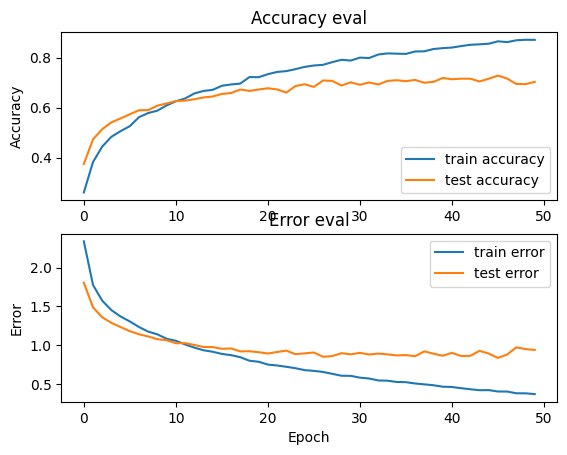

32/32 - 1s - loss: 1.2713 - accuracy: 0.6202

Test accuracy: 0.6202405095100403
MODEL SUCESSFULLY SAVED AT D:/Downloads/MGR Data/Models/EXPERIMENT 6.h5
Training Execution Time : 457.88192558288574 Seconds


In [17]:
training(MEMORY_MAPPING_PATH,ERROR_PATH,MODEL_SAVE_DIRECTORY,DATASET_PATH,CSV_PATH,TEST_CSV_PATH,remove=True)